In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from scipy import signal

In [2]:
def crosscorrEx(tshift=.1,tfin=2,fa=2,plots=False,NoiseAmp=1):

    #Modified Cross-correlation example for sine wave
    fs=10*fa
    t=np.arange(0,tfin,1/(50*fs))
    t2=np.arange(0,tfin+1/(50*fs),1/(50*fs))

    nsamples=t.size
    dt=np.arange(1-nsamples,nsamples)
    
    sig=np.sin(2*np.pi*fa*t)
    sig2=np.roll(np.sin(2*np.pi*fa*t2),int(tshift*50*fs))
    np.random.seed(42069)
    sig_noise = sig2 + NoiseAmp*np.random.randn(len(sig2))

    sig-= sig.mean(); sig/= sig.std()
    sig2-= sig2.mean(); sig2/= sig2.std()
    sig_noise-= sig_noise.mean(); sig_noise/= sig_noise.std()

    corr = signal.correlate(sig_noise, sig, mode='full')#,mode='full',method='fft')/(len(sig))
    corridx=corr.argmax()
    tadj=dt[corridx]/(50*fs)
#     print('First try',tadj,corridx)
    while np.abs(tadj)>(1/fa):
        corridx=corr[len(sig)-int(50*fs/(2*fa)):len(sig)+int(50*fs/(2*fa))].argmax()
        tadj=dt[corridx+len(sig)]/(50*fs)
#         print('Better?', tadj,corridx+len(sig))
        break
    # tadj=(np.argmax(corr)-len(sig))/(50*fs)
    sig_adj=np.sin(2*np.pi*fa*(t-(tshift-tadj)))
    sig_adj-=sig_adj.mean();sig_adj/=sig_adj.std()

    if plots==True:
        fig, (ax_orig, ax_noise, ax_corr, ax_adj) = plt.subplots(4, 1)#, sharex=True)
        ax_orig.plot(t*50*fs,sig,t2*50*fs,sig2)
        ax_orig.set_title('Original signal')
        ax_noise.plot(sig_noise)
        ax_noise.set_title('Signal with noise')
        ax_corr.plot(corr)
        ax_adj.plot(t*50*fs,sig,t*50*fs,sig_adj)
        fig.tight_layout()
        fig.show()
        
    return tadj
#     print('Time lag should be', tshift, 's')
#     print('Detected lag is', (np.argmax(corr)-len(sig))/(50*fs),' s  or by other method:', t[corr.argmax()-len(sig)])
#     print('Cross correlation error', (tshift-tadj)*360*fa, 'degrees')

[0.18 0.18 0.18]


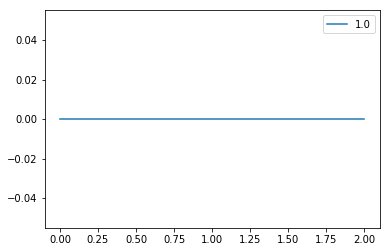

In [10]:
reps=3
tshift=.18
tfin=20
fa=2

results=np.zeros(reps)
idx=np.arange(0,reps)

fig, (ax_orig)=plt.subplots(1,1)

for j in np.arange(0,.08,.1):
    NoiseAmp=10**j
    for i in idx:
        results[i]=crosscorrEx(tshift=tshift,tfin=tfin,fa=fa,plots=False,NoiseAmp=NoiseAmp)


    Errors=(tshift-results)*fa*360
    ax_orig.plot(idx,Errors,label=str(NoiseAmp))
    print(results)
plt.legend()
plt.show()

In [ ]:
#Orignal Cross-correlation example
sig = np.repeat([0., 1., 1., 0., 1., 0., 0., 1.], 128)
sig_noise = sig + np.random.randn(len(sig))
corr = signal.correlate(sig_noise, np.ones(128), mode='same') / 128

clock = np.arange(64, len(sig), 128)
fig, (ax_orig, ax_noise, ax_corr) = plt.subplots(3, 1, sharex=True)
ax_orig.plot(sig)
ax_orig.plot(clock, sig[clock], 'ro')
ax_orig.set_title('Original signal')
ax_noise.plot(sig_noise)
ax_noise.set_title('Signal with noise')
ax_corr.plot(corr)
ax_corr.plot(clock, corr[clock], 'ro')
ax_corr.axhline(0.5, ls=':')
ax_corr.set_title('Cross-correlated with rectangular pulse')
ax_orig.margins(0, 0.1)
fig.tight_layout()

fig.show()

Added time shift:  100
Recovered time shift:  100
30099 [30099]


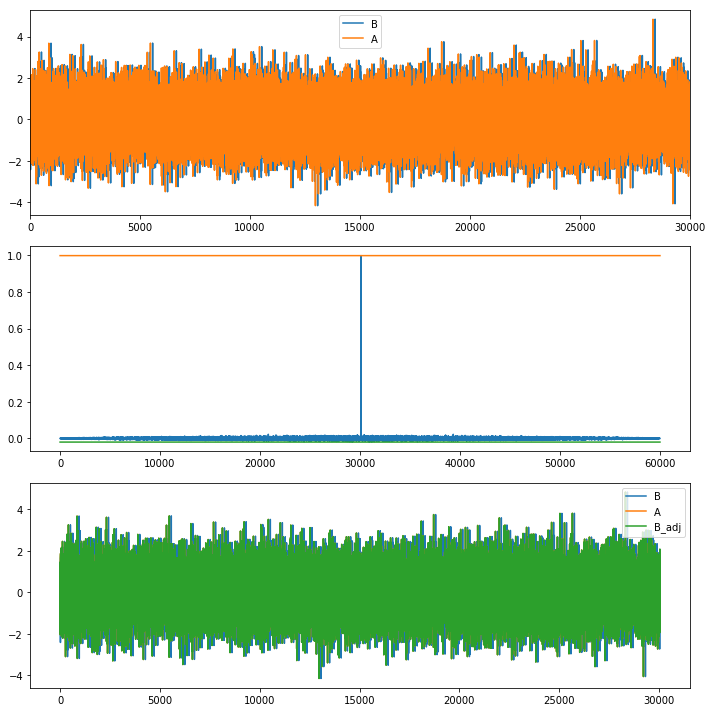

In [9]:
tfin=30
fa=2
NoiseAmp=.01

fs=10*fa
t=np.arange(0,tfin,1/(50*fs))
t2=np.arange(0,tfin+50/(50*fs),1/(50*fs))

# A =np.sin(2*np.pi*fa*t)
# B = np.sin(2*np.pi*fa*t) + NoiseAmp*np.random.randn(len(t))

np.random.seed(42069)
A=NoiseAmp*np.random.randn(len(t))
np.random.seed(42069)
B=NoiseAmp*np.random.randn(len(t2))
nsamplesA = A.size
nsamplesB = B.size

# regularize datasets by subtracting mean and dividing by s.d.
A -= A.mean(); A /= A.std()
B -= B.mean(); B /= B.std()

# Put in an artificial time shift between the two datasets
time_shift = +100
B = np.roll(B, time_shift)

# Find cross-correlation
xcorr = signal.correlate(B,A,mode='full',method='fft')/(np.mean([nsamplesA,nsamplesB]))

# delta time array to match xcorr
dt = np.arange(1-nsamplesA, nsamplesB)

recovered_time_shift = dt[xcorr.argmax()]
peaks,_=signal.find_peaks(xcorr,height=.97*xcorr.max())

print('Added time shift: ', time_shift)
print('Recovered time shift: ', recovered_time_shift)
print(xcorr.argmax(),peaks)

B_adj=np.roll(B,-recovered_time_shift)

fig, (ax_sigs, ax_corr, ax_rest)= plt.subplots(3, 1,figsize=(10,10))

# C=np.roll(B,-recovered_time_shift)
# ax_rest.plot(C)

ax_sigs.plot(B,label='B')
ax_sigs.plot(A,label='A')
ax_sigs.set_xlim(0,nsamplesB)
ax_sigs.legend()
ax_corr.plot(xcorr)
ax_corr.plot(np.repeat(xcorr.max(),len(xcorr)))
ax_corr.plot(np.repeat(xcorr.min(),len(xcorr)))
# ax_corr.set_xlim(len(A)-3*50*fs/fa,len(A)+3*50*fs/fa)

ax_rest.plot(B,label='B')
ax_rest.plot(A,label='A')
ax_rest.plot(B_adj,label='B_adj')
ax_sigs.set_xlim(0,nsamplesA)
ax_rest.legend()
fig.tight_layout()
fig.show()
